# Process scRNA for label transfer
Please, save the anndata object as follows

```
# adata_count = anndata.AnnData(X=np.expm1(adata.raw.X), var=adata.raw.var, obs=adata.obs, asview=False)
# adata_count.write('data/organoids-all-TC-keep-ccg_forSeurat.h5ad')
```


In [1]:
# If problems installing slingshot
# sudo apt-get update
# sudo apt-get install libglu1-mesa-dev 
# sudo apt-get install freeglut3-dev
# sudo apt-get install mesa-common-dev
# then
# install.packages("rgl")
# BiocManager::install("slingshot")
library(Seurat)
library(dplyr)
library(RColorBrewer)
library(destiny, quietly = TRUE)
library(gam)
library(harmony)
library(ggplot2)
library(pheatmap)
library(cowplot)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: splines

Loading required package: foreach

Loaded gam 1.16.1


Loading required package: Rcpp


********************************************************

Note: As of version 1.0.0, cowplot does not change the

  default ggplot2 theme anymore. To recover the previous

  behavior, execute:
  theme_set(theme_cowplot())

********************************************************




In [2]:
sessionInfo()

R version 4.0.0 (2020-04-24)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.3 LTS

Matrix products: default
BLAS/LAPACK: /home/jovyan/my-conda-envs/R4/lib/libopenblasp-r0.3.9.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] splines   stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] cowplot_1.0.0      pheatmap_1.0.12    ggplot2_3.3.1      harmony_1.0       
 [5] Rcpp_1.0.4.6       gam_1.16.1         foreach_1.5.0      destiny_3.2.0     
 [9] RColorBrewer_1.1-2 dplyr_1.0.0        Seurat_3.1.5      

loaded via a namespace (and not attached):
  [1] readxl_1.3.1      

In [3]:
# we know these genes are relevant, use them to keep track on how good we're doing
known_genes = c('TOP2A', 'PCNA', 'LGR6', 'KRT5',
           'SOX9', 'MMP7', 'WNT7A', 'KRT13',
           'PLAU',  'PLAUR', 'SCGB2A1', 'PAEP', 
           'SPP1', 'SCGB2A2', 'HEY1', 'SERPINA1', 
           'TP73', 'FOXJ1', 'PIFO', 'RSPH1', 'PGR')

# Process with Seurat from raw

In [4]:
# Load and pre-process wth standard workflow
anndata <- ReadH5AD(file = 'data/organoids-confI_Donor19_forSeurat.h5ad')
allgenes = rownames(anndata)
anndata

Pulling expression matrices and metadata

Data is unscaled

Creating assay object

Storing X as raw and raw as counts

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
No variable feature expression found in h5ad file

No dimensional reduction information found

Assembling Seurat object

No nearest-neighbor graph

No additional layers found



An object of class Seurat 
21709 features across 20411 samples within 1 assay 
Active assay: RNA (21709 features, 0 variable features)

In [5]:
# basic preprocessing
anndata <- NormalizeData(anndata, normalization.method = "LogNormalize", scale.factor = 10000)

In [6]:
table(is.na(rownames(anndata)[ anndata@assays$RNA@meta.features$is.HVG ] ))


FALSE  TRUE 
 2201     5 

In [7]:
anndata = subset(anndata, features = rownames(anndata)[ anndata@assays$RNA@meta.features$is.HVG ] )
anndata <- FindVariableFeatures(anndata, nfeatures = 20000)
anndata <- ScaleData(anndata, features = rownames(anndata))

Warning message in subset.Assay(x = x[[assay]], cells = cells, features = assay.features):
“NAs passed in the features vector, removing NAs”
Centering and scaling data matrix



In [8]:
# # check cell cycle effect
# anndata <- CellCycleScoring(anndata, s.features = cc.genes$s.genes, g2m.features = cc.genes$g2m.genes, set.ident = TRUE)
# anndata <- RunPCA(anndata, features = c(cc.genes$s.genes, cc.genes$g2m.genes))
# DimPlot(anndata, reduction = 'pca')

In [9]:
# # Regress out cell cycle - NOTE: subset the dataset to speed up process
# anndata = subset(anndata, features = VariableFeatures(object = anndata))
# anndata <- ScaleData(anndata, vars.to.regress = c("S.Score", "G2M.Score"), features = rownames(anndata))

PC_ 1 
Positive:  TPPP3, FAM92B, DNAH12, CCDC170, ROPN1L, FAM183A, C11orf97, ODF3B, TEKT1, SNTN 
	   C1orf194, MORN5, C9orf24, ENKUR, LRRC46, CAPSL, CDC20B, C5orf49, ZMYND10, SMIM6 
	   CCNA1, RIIAD1, ERICH3, STMND1, CFAP53, RSPH4A, SAXO2, EFCAB1, C11orf70, C7orf57 
Negative:  S100A16, FBL, SRM, MMP7, DBI, TUBB, IER3, COTL1, CALD1, KRT23 
	   C19orf48, MALT1, ENC1, CLDN1, CCND1, EPB41L4A-AS1, KLK6, COL4A1, CD320, COL4A2 
	   PHLDA3, LMO4, TPD52L1, TPM1, FGF18, ALDH1A1, PHLDA1, TM4SF1, LDHA, KRT7 
PC_ 2 
Positive:  LCN2, PERP, KRT13, LYPD3, S100A11, HSPB1, CLIC3, SPINK5, CEACAM6, SLPI 
	   DSC2, NCCRP1, LIPH, S100A9, KLF4, MUC16, FAM3D, SCEL, FXYD3, FGFBP1 
	   IGF2, LGALS3, C15orf48, SLC6A14, DSP, NDRG1, NDRG2, TACSTD2, MALL, AQP3 
Negative:  HSPD1, STMN1, FBL, HMGB1, VIM, DCDC2, TUBA1B, CD320, TUBB, H2AFZ 
	   NASP, HNRNPA2B1, HMGN3, RANBP1, NUCKS1, COTL1, HSP90AA1, DEK, PARP1, TPM1 
	   HMGB3, PTGES3, HMGN2, HNRNPM, C12orf75, LSM4, CTNNAL1, ALDH1A1, CKS2, PTTG1 
PC_ 3 
Positive:  KRT

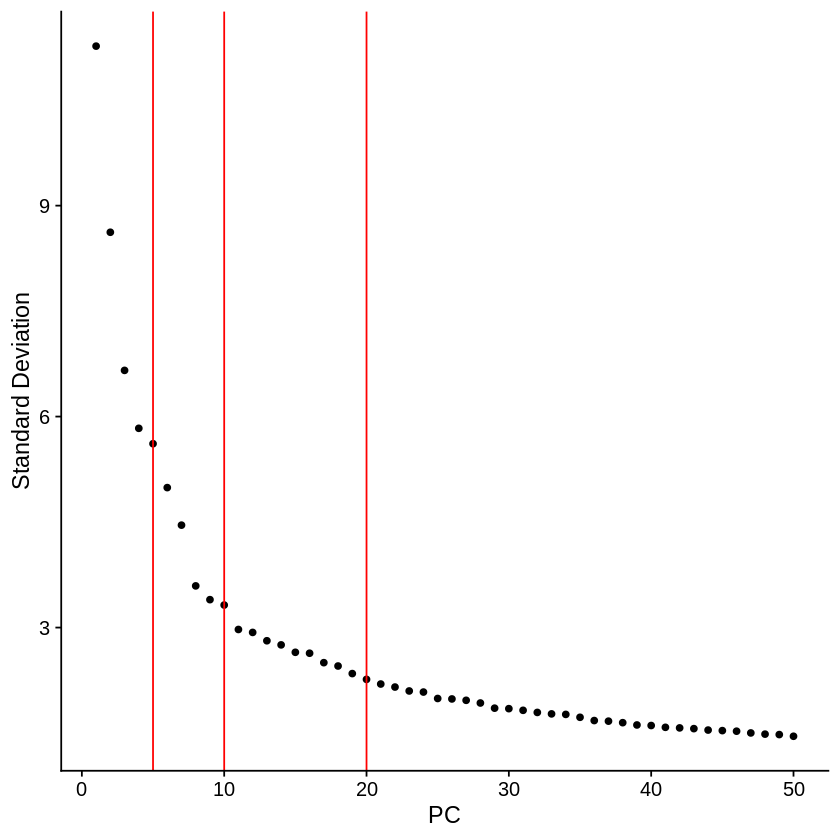

In [10]:
# # Compute PCA
anndata <- RunPCA(anndata, features = VariableFeatures(object = anndata), seed.use = 1)
ElbowPlot(anndata, ndims = 50) + geom_vline(xintercept = 5, color = 'red') + geom_vline(xintercept = 10, color = 'red') + geom_vline(xintercept = 20, color = 'red')

In [11]:
npca = 10
# Correct donor's effect on PCA
# anndata <- RunHarmony(anndata, group.by.vars = 'Donor', dims.use = 1:npca, theta = 2)

In [12]:
# Cluster
anndata <- FindNeighbors(anndata, dims = 1:npca, reduction = "pca", verbose = F)
anndata <- RunUMAP(anndata, dims = 1:npca, reduction = "pca", verbose = F)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


Warning message:
“Using `as.character()` on a quosure is deprecated as of rlang 0.3.0.
Please use `as_label()` or `as_name()` instead.
This warning is displayed once per session.”


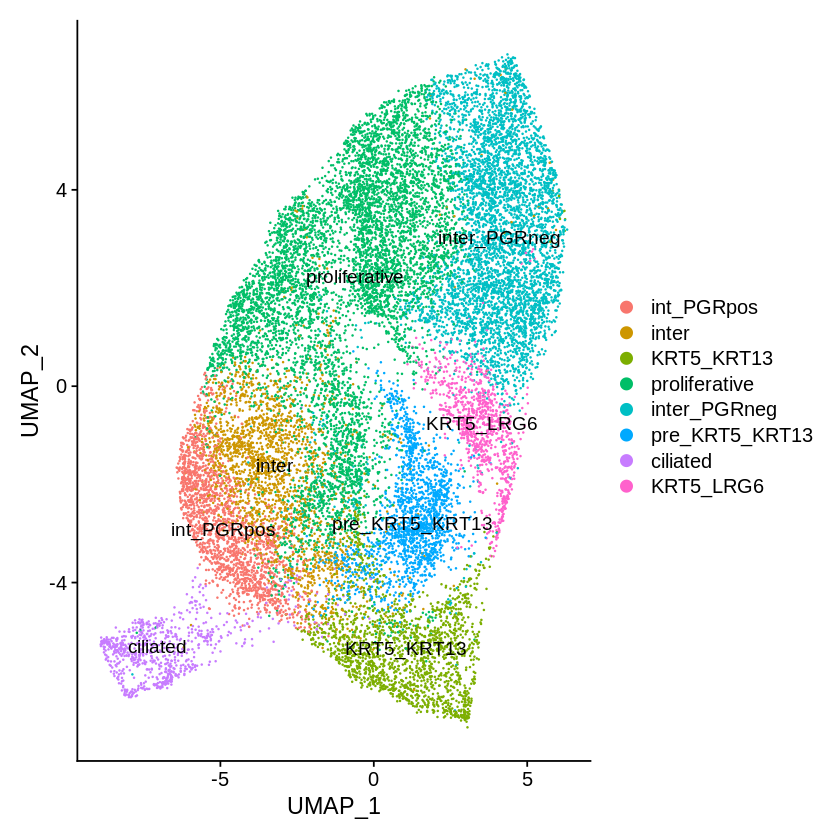

In [13]:
# Plot previous cluster
clustering = read.csv('figures_organoid_confInhibitors/Donor19/barcode_metadata.csv', stringsAsFactors = F)
rownames(clustering) = clustering$index
anndata@meta.data$clusters = clustering[rownames(anndata@meta.data), ]$clusters

# Assign identities and check
Idents(anndata) <- anndata@meta.data$clusters
DimPlot(anndata, reduction = "umap", label = T)

Warning message in FetchData(object = object, vars = c(dims, "ident", features), :
“The following requested variables were not found: TOP2A, PCNA, PAEP, SCGB2A2, PGR”
Warning message in FetchData(object = object, vars = c(dims, "ident", features), :
“The following requested variables were not found: PAEP, SCGB2A2”


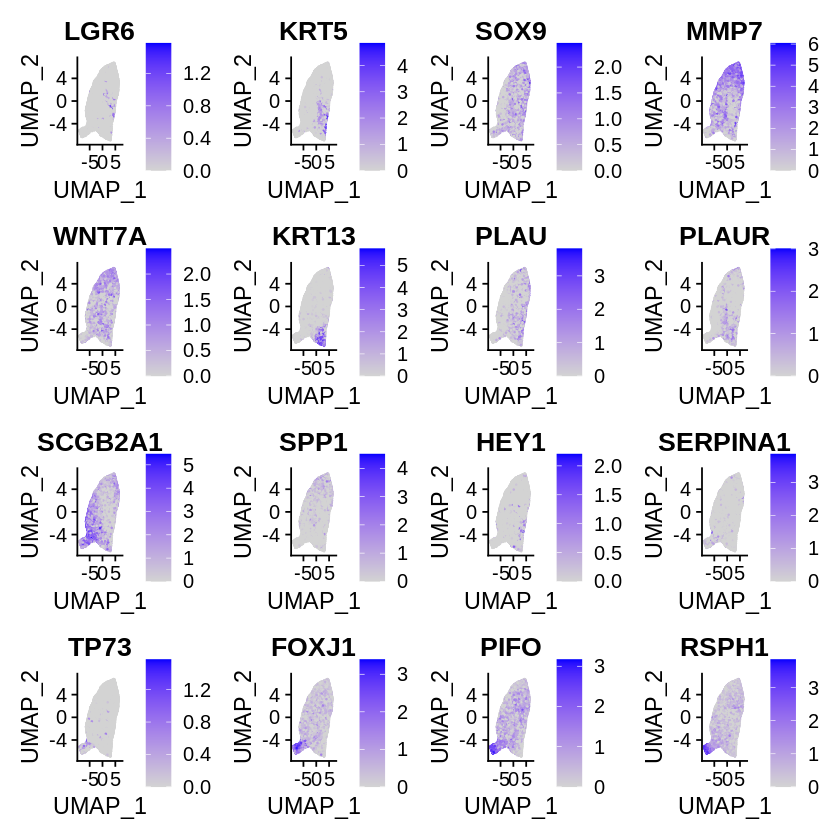

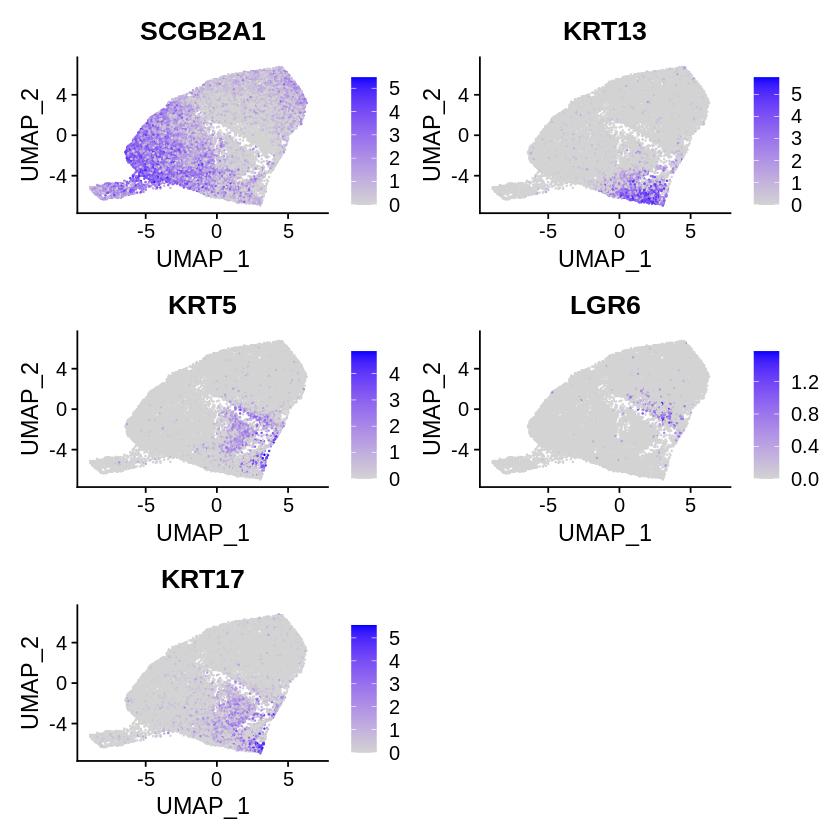

In [14]:
FeaturePlot(anndata, features = known_genes, ncol = 4)
ggsave(device = 'pdf', file = 'figures_organoid_confInhibitors/Donor19/seurat_umap_markerGenes.pdf', width = 15, height = 15)
FeaturePlot(anndata, features = c('PAEP','SCGB2A2','SCGB2A1','KRT13', 'KRT5', 'LGR6', 'KRT17'))

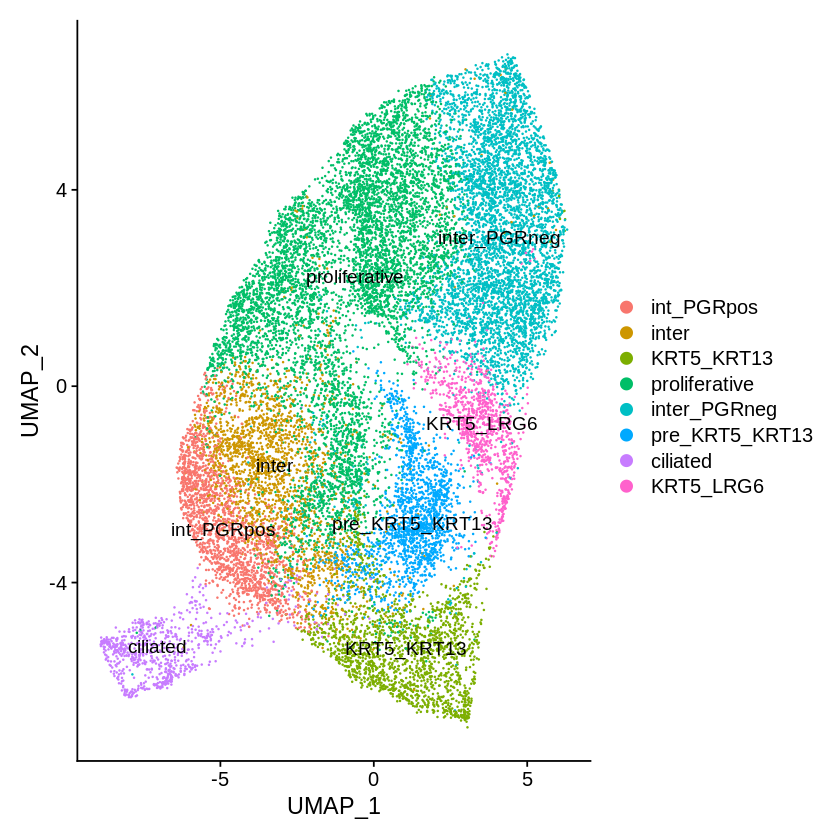

In [15]:
# Plot previous cluster
clustering = read.csv('figures_organoid_confInhibitors/Donor19/barcode_metadata.csv', stringsAsFactors = F)
rownames(clustering) = clustering$index
anndata@meta.data$clusters = clustering[rownames(anndata@meta.data), ]$clusters

# Assign identities and check
Idents(anndata) <- anndata@meta.data$clusters
DimPlot(anndata, reduction = "umap", label = T)

In [16]:
#save
saveRDS(anndata, file = '~/farm/endometrium/data/scATAC/organoidsI_Donor19_scRNA_seuratobject.rds')

In [17]:
markers = FindAllMarkers(anndata, test.use = 'LR')
write.csv(markers, file = 'figures_organoid_confInhibitors/Donor19/seurat_markers.csv')

Calculating cluster int_PGRpos

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Calculating cluster inter

Calculating cluster KRT5_KRT13

Calculating cluster proliferative

Calculating cluster inter_PGRneg

Calculating cluster pre_KRT5_KRT13

Calculating cluster ciliated

Calculating cluster KRT5_LRG6



In [18]:
lapply(levels(Idents(anndata)), function(x) head(subset(markers, cluster == x))  )

,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
SCGB2A1,0,1.823879,0.989,0.671,0,int_PGRpos,SCGB2A1
CLDN10,0,1.478352,0.988,0.672,0,int_PGRpos,CLDN10
SCGB1D2,0,1.410664,0.824,0.188,0,int_PGRpos,SCGB1D2
WFDC2,0,1.201001,0.937,0.788,0,int_PGRpos,WFDC2
SOX17,0,1.124639,0.944,0.525,0,int_PGRpos,SOX17
ASRGL1,0,1.002720,0.998,0.826,0,int_PGRpos,ASRGL1
,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
SCGB2A1.1,0.000000e+00,0.9371677,0.946,0.671,0.000000e+00,inter,SCGB2A1
